In [20]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

from copy import copy

from torchdiffeq import odeint, odeint_adjoint

import torch
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam, pyro_method
from pyro.nn.module import to_pyro_module_
from pyro.poutine import trace
from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam

In [21]:
def plot_predictive(prediction, data, title=""):
    t = np.linspace(0, 160, 160)
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    vars = ["S_obs", "V_obs", "I_obs", "Iv_obs", "R_obs"]
    S, V, I, Iv, R = [d.detach().numpy()/1000 for d in data]

    S_low, V_low, I_low, Iv_low, R_low = [torch.quantile(prediction[k], 0.05, dim=0).detach().numpy()/1000 for k in vars]
    S_up, V_up, I_up, Iv_up, R_up = [torch.quantile(prediction[k], 0.95, dim=0).detach().numpy()/1000 for k in vars]

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.fill_between(t, S_low, S_up, color='b', alpha=0.2)
    ax.plot(t, V, 'purple', alpha=0.5, lw=2, label='SucceptibleVaccinated')
    ax.fill_between(t, V_low, V_up, color='purple', alpha=0.2)
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.fill_between(t, I_low, I_up, color='r', alpha=0.2)
    ax.plot(t, Iv, 'green', alpha=0.5, lw=2, label='InfectedVaccinated')
    ax.fill_between(t, Iv_low, Iv_up, color='green', alpha=0.2)
    ax.plot(t, R, 'orange', alpha=0.5, lw=2, label='Recovered')
    ax.fill_between(t, R_low, R_up, color='orange', alpha=0.2)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title(title)
    plt.show()

In [22]:
def get_tspan(start, end, steps):
    return torch.linspace(float(start), float(end), steps)

In [23]:
class SVIIvR(PyroModule):
    def __init__(self, 
                N,
                noise_prior=dist.Uniform(1., 10.),
                beta_prior=dist.Uniform(0.15, 0.25), 
                betaV_prior=dist.Uniform(0.1, 0.2),
                gamma_prior=dist.Uniform(0.05, 0.15),
                gammaV_prior=dist.Uniform(0.1, 0.2),
                nu_prior=dist.Uniform(0.02, 0.08),
                ):
        super().__init__()

        self.N = N
        self.noise_prior  = noise_prior
        self.beta_prior   = beta_prior
        self.betaV_prior  = betaV_prior
        self.gamma_prior  = gamma_prior
        self.gammaV_prior = gammaV_prior
        self.nu_prior     = nu_prior
        
    def forward(self, t, state):
        S, V, I, Iv, R = state
        dSdt  = -self.beta  * S * I  / self.N - self.beta  * S * Iv / self.N - self.nu * S 
        dVdt  = -self.betaV * V * Iv / self.N - self.betaV * V * I  / self.N + self.nu * S
        dIdt  =  self.beta  * S * I  / self.N + self.beta  * S * Iv / self.N - self.gamma  * I 
        dIvdt = self.betaV * V * I  / self.N + self.betaV * V * Iv / self.N - self.gammaV * Iv 
        dRdt  =  self.gamma * I + self.gammaV * Iv

        return dSdt, dVdt, dIdt, dIvdt, dRdt

    @pyro_method
    def param_prior(self):
        self.noise_var = pyro.sample("noise_var", self.noise_prior)
        self.beta      = pyro.sample("beta", self.beta_prior)
        self.betaV     = pyro.sample("betaV", self.betaV_prior)
        self.gamma     = pyro.sample("gamma", self.gamma_prior)
        self.gammaV    = pyro.sample("gammaV", self.gammaV_prior)
        self.nu        = pyro.sample("nu", self.nu_prior)


    @pyro_method
    def observation_model(self, solution, data):
        S_, V_, I_, Iv_, R_ = solution

        # It's a little clunky that we have to do `None` handling for each implementation of 'observation_model'...
        # TODO: abstract out.
        
        if data == None:
            data = {k: None for k in ["S_obs", "V_obs", "I_obs", "Iv_obs", "R_obs"]}

        S = pyro.sample("S_obs", dist.Normal(S_, self.noise_var).to_event(1), obs=data["S_obs"])
        V = pyro.sample("V_obs", dist.Normal(V_, self.noise_var).to_event(1), obs=data["V_obs"])
        I = pyro.sample("I_obs", dist.Normal(I_, self.noise_var).to_event(1), obs=data["I_obs"])
        Iv = pyro.sample("Iv_obs", dist.Normal(Iv_, self.noise_var).to_event(1), obs=data["Iv_obs"])
        R = pyro.sample("R_obs", dist.Normal(R_, self.noise_var).to_event(1), obs=data["R_obs"])

        return S, V, I, Iv, R


    @pyro_method
    def simulate(self, initial_state, tspan, data=None):
        
        # Sample parameters from the prior
        self.param_prior()

        # Simulate from ODE
        solution = odeint(self, initial_state, tspan)
        
        # Add Observation noise
        observations = self.observation_model(solution, data)

        return observations


In [24]:
# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0.0, 1.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))
tspan = get_tspan(0, 160, 160)

In [16]:
# Generate data
ode_model = SVIIvR(N)
S_obs, V_obs, I_obs, Iv_obs, R_obs = ode_model.simulate(initial_state, tspan)

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_54339/161055048.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


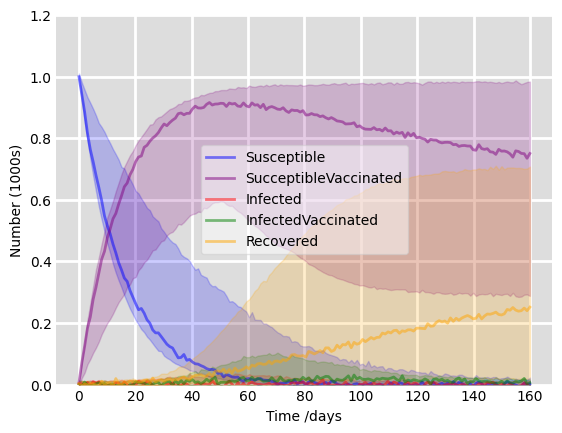

In [17]:
prior_prediction = Predictive(ode_model.simulate, num_samples=100)(initial_state, tspan)
plot_predictive(prior_prediction, (S_obs, V_obs, I_obs, Iv_obs, R_obs))

In [18]:
verbose = True
num_iterations = 250

guide = AutoNormal(ode_model.simulate)
optim = Adam({'lr':0.03})
elbo = Trace_ELBO(num_particles=1)

svi = SVI(ode_model.simulate, guide, optim, loss=elbo)

pyro.clear_param_store()

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(initial_state, tspan, S_obs=S_obs, V_obs=V_obs, I_obs=I_obs, Iv_obs=Iv_obs, R_obs=R_obs)
    if verbose:
        if j % 25 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))

[iteration 0001] loss: 29674.9252
[iteration 0026] loss: 4193.7779
[iteration 0051] loss: 3946.8767
[iteration 0076] loss: 3705.6530
[iteration 0101] loss: 2909.7101
[iteration 0126] loss: 3322.4384
[iteration 0151] loss: 2585.5262
[iteration 0176] loss: 2634.1601
[iteration 0201] loss: 2580.0761
[iteration 0226] loss: 2644.7821


/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_54339/161055048.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


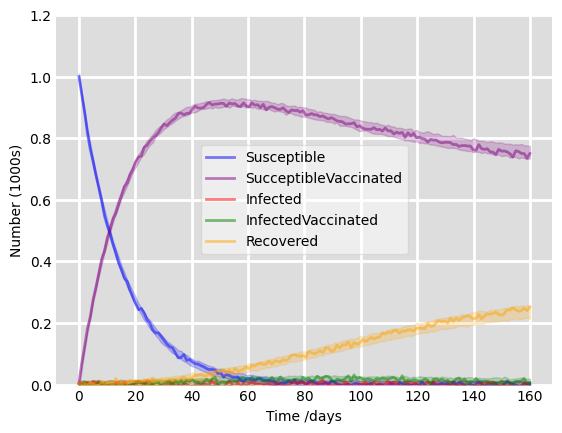

In [19]:
posterior_prediction = Predictive(ode_model.simulate, guide=guide, num_samples=100)(initial_state, tspan)
plot_predictive(posterior_prediction, (S_obs, V_obs, I_obs, Iv_obs, R_obs))

In [10]:
## Action Selection